# 1. Загрузим исходный данные в базу данных SQLite

In [ ]:
# Импортируем библиотеки
import csv
import sqlite3 as sql

In [ ]:
# Создаем базу данных bascet.db и создаем с ней соединение
conn= sql.connect("bascet.db")

In [ ]:
# В базе данных создаем
conn.execute('''
CREATE TABLE sessons (
    player_name         TEXT,
    team_abbreviation   TEXT,
    age                 INTEGER,
    player_height       TEXT,
    player_weight       TEXT,
    college             TEXT,
    country             TEXT,
    draft_year          INTEGER,
    draft_round         INTEGER,
    draft_number        INTEGER,
    gp                  INTEGER,
    pts                 TEXT,
    reb                 TEXT,
    ast                 TEXT,
    net_rating          TEXT,
    oreb_pct            TEXT,
    dreb_pct            TEXT,
    usg_pct             TEXT,
    ts_pct              TEXT,
    ast_pct             TEXT,
    season              TEXT
)''')

In [ ]:
with open('/content/drive/MyDrive/dataset.csv', encoding= 'utf-8') as file:
  df= csv.reader(file)
  for row in list(df)[1:]:
    row = [i if i not in ('None', 'Undrafted') else None for i in row]
    conn.execute("INSERT INTO sessons VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", row[1:])

# 2.Подготовка данных для построния моделей

In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Из базы данных, sql запросом, вытаскиваем необходимые для дальнейшего анализа столбцы, группируем данные по имени игрока, тем самым убираем задвои игроков.
df = pd.read_sql('''SELECT player_name,
                          player_height,
                          player_weight
                          FROM sessons''', conn)

In [ ]:
# Меняем тип полей на float64
df = df.astype({'player_height': np.float64, 'player_weight': np.float64 })

In [ ]:
df= df.groupby('player_name').mean()

In [ ]:
df.describe()

,player_height,player_weight
count,2463.000000,2463.000000
mean,200.163490,99.409815
std,9.082196,12.375046
min,160.020000,60.327736
25%,193.040000,90.718400
50%,200.660000,98.883056
75%,207.010000,108.689283
max,231.140000,163.293120


In [ ]:
# Разделяем выборку на x,y
Y= df['player_height']
X= df['player_weight']

Text(0.5, 1.0, ' График взаимозависимости роста и веса спортсмена')

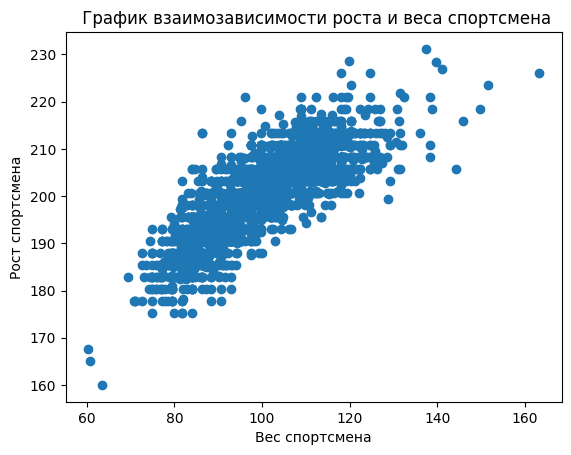

In [ ]:
plt.scatter(X,Y)
plt.ylabel("Рост спортсмена")
plt.xlabel("Вес спортсмена")
plt.title(" График взаимозависимости роста и веса спортсмена")

#Построение модели линейной регрессии

In [ ]:
# Импорт необходимых функций из библиотеки sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Разделения массива данных на треенировочную и тестовую.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=160)

In [ ]:
# Так как для построения модели требуется 2- х мерный массив добавляем к x_train, x_test еще один столбец состоящий из Nan
x_train, x_test = x_train[:, np.newaxis], x_test[:, np.newaxis]

<ipython-input-14-156b02256ff0>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_train, x_test = x_train[:, np.newaxis], x_test[:, np.newaxis]


In [ ]:
#Инициализируем и обучаем модель линейной регрессии
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression()

Точность линейной регрессии составила 71.0 %


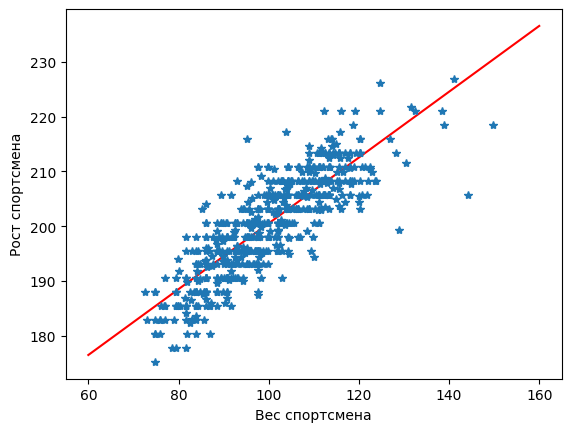

In [ ]:
# Визуализируем полученный результат  и выведем точность регрессии
xfit = np.linspace(60, 160)
yfit = linear_model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit, color= 'r')
plt.plot(x_test, y_test, '*')
plt.ylabel("Рост спортсмена")
plt.xlabel("Вес спортсмена")
print(f'Точность линейной регрессии составила {round(linear_model.score(x_test, y_test)*100, 0)} %')

# Построим модель полимиальной регрессии

In [ ]:
 # Импортируем необходимые библиотеки
 from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# С помощью цикла переберем степени полинома от 1, 50 и выберем наилучший результата
degree = [i for i in range(1,51)]
model_train, model_test = [], []
for d in degree:
  poly_model = PolynomialFeatures(degree=d)
  x_poly = poly_model.fit_transform(x_train)
  lin_reg = LinearRegression()
  lin_reg.fit(x_poly, y_train)
  model_train.append(round(lin_reg.score(x_poly, y_train)*100,0))
  model_test.append(round(lin_reg.score(poly_model.fit_transform(x_test), y_test)*100, 0))


Text(0.5, 1.0, 'График зависимости точности полиномиальной модели от степени полинома')

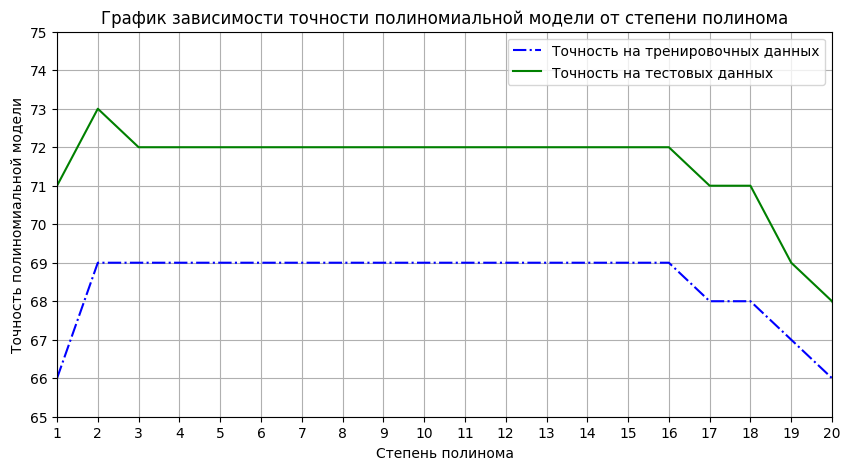

In [ ]:
#Визуализируем полученный результат
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(degree, model_train, color='blue', label= 'Точность на тренировочных данных', linestyle='-.')
plt.plot(degree, model_test, color='green', label= 'Точность на тестовых данных', linestyle='-')
plt.axis([1, 20, 65, 75])
plt.yticks([ i for i in range(65, 76)])
plt.xticks([ i for i in range(1, 21)])
plt.legend()
plt.xlabel('Степень полинома')
plt.ylabel('Точность полиномиальной модели')
plt.title('График зависимости точности полиномиальной модели от степени полинома')

# Вывод лучшый параметр для полиномиальной функции является степень полинома 2.

Точность полиномиальной  регрессии составила 73.0 %


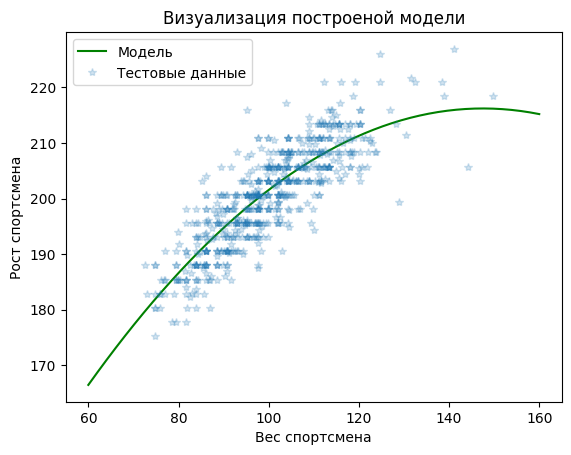

In [ ]:
# Обучем модель на лучших параметрах, выведем скоринг модели и визуализируем полученные результаты
# Вызов модели и ее обучение
p_model = PolynomialFeatures(degree=2)
lin_p_model =LinearRegression()
lin_p_model.fit(p_model.fit_transform(x_train), y_train)
# Скоринг и визуализация
xfit_poly = np.linspace(60, 160)
yfit_poly = lin_p_model.predict(p_model.fit_transform(xfit_poly[:, np.newaxis]))
plt.plot(xfit_poly, yfit_poly, color= 'green', label= "Модель")
plt.plot(x_test, y_test, '*', label= "Тестовые данные", alpha= 0.2)
plt.ylabel("Рост спортсмена")
plt.xlabel("Вес спортсмена")
plt.legend()
plt. title('Визуализация построеной модели')
print(f'Точность полиномиальной  регрессии составила {round(lin_p_model.score(p_model.fit_transform(x_test), y_test)*100, 0)} %')

# Построим модель SVM

In [ ]:
#Импортируем необходимые библиотеки
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [ ]:
# C помощью GridSearchCV подбираем лучшие параметры модели SVR
parrams ={'kernel' : ["linear", "rbf", "sigmoid"], 'C': [1, 0.1, 0.5, 2,100], "degree":[1,2,3], "gamma":['scale', 'auto']}
grid= GridSearchCV(SVR(), parrams, refit=True, verbose=4)
grid.fit(x_train, y_train)
print(f"Лучшие параметры модели: {grid.best_params_}")

Точность модели SVR составила 73.0 %


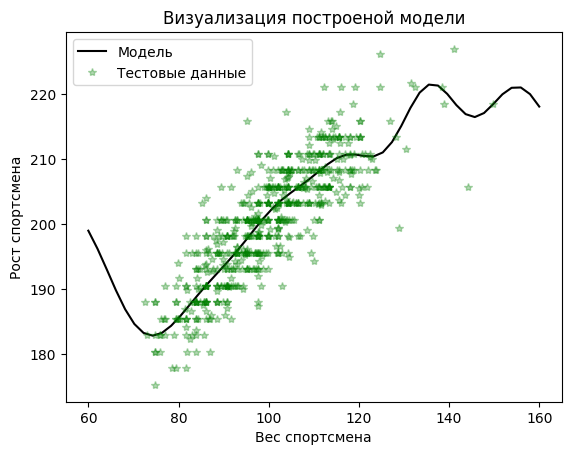

In [ ]:
#Инициализируем и обучаем модель SVR с лучшими параметрами
model_svr= SVR(kernel='rbf', degree=1, gamma='scale', C=100)
model_svr.fit(x_test, y_test)

#Визуализация результата
xfit_svr = np.linspace(60, 160)
yfit_svr = model_svr.predict(xfit_poly[:, np.newaxis])
plt.plot(xfit_svr, yfit_svr, color= 'black', label= "Модель")
plt.plot(x_test, y_test, '*', label= "Тестовые данные", color='green', alpha= 0.3)
plt.ylabel("Рост спортсмена")
plt.xlabel("Вес спортсмена")
plt.legend()
plt. title('Визуализация построеной модели')
print(f'Точность модели SVR составила {round(model_svr.score(x_test, y_test)*100, 0)} %')

#Подготовка данных для построения модели дерева решений

In [ ]:
# Импортируем необходимые данные из ранее созданной sql-базы
df2 =pd.read_sql("""SELECT team_abbreviation, pts, reb, ast, player_height, player_weight FROM sessons WHERE season='2010-11'""", conn)

In [ ]:
df2.head()

,team_abbreviation,pts,reb,ast,player_height,player_weight
0,DAL,2.3,1.4,1.1,195.58,97.52228000000001
1,NYK,16.8,2.6,5.4,190.5,95.25432
2,DEN,5.6,4.9,0.4,208.28,103.418976
3,MIA,18.7,8.3,1.9,210.82,106.59411999999999
4,MIL,7.3,2.0,1.1,200.66,95.25432


In [ ]:
df2.columns

Index(['team_abbreviation', 'pts', 'reb', 'ast', 'player_height',
       'player_weight'],
      dtype='object')

In [ ]:
# Меняем тип полей с текстового на число с плавающей точкой
df2 = df2.astype({'player_height': np.float64, 'player_weight': np.float64, 'pts': np.float64, 'reb': np.float64, 'ast': np.float64 })

In [ ]:
# Проверяем результат
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_abbreviation  452 non-null    object 
 1   pts                452 non-null    float64
 2   reb                452 non-null    float64
 3   ast                452 non-null    float64
 4   player_height      452 non-null    float64
 5   player_weight      452 non-null    float64
dtypes: float64(5), object(1)
memory usage: 21.3+ KB


# Построение модели дерево решений вариант 1

> Блок с отступами



In [ ]:
# Группируем данные по названию команды, по остальным столбцам берем среднее значение каждой команды
train_data= df2.groupby('team_abbreviation').mean()

In [ ]:
# Сбрасываем индекс с таблицы.
train_data.reset_index(inplace=True)

In [ ]:
# Разделем предикторы и целевые значения (в качестве целевых значений берем индекс строки)
Y= np.array(train_data.index)
X = train_data.drop(['team_abbreviation'], axis=1)

In [ ]:
X.describe()

,pts,reb,ast,player_height,player_weight
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,8.242503,3.564686,1.775043,201.213148,101.636730
std,0.705245,0.279750,0.171156,1.238058,2.346399
min,6.668750,3.070588,1.441176,198.966667,97.629008
25%,7.741458,3.345000,1.663854,200.194333,99.893378
50%,8.286667,3.580000,1.773958,200.998667,101.231062
75%,8.565848,3.735882,1.923214,202.241394,103.659947
max,9.766667,4.133333,2.057143,203.369333,106.282275


#  Так как данные столбцов предикторов имеют сильный разброс, то перед построением модели необходимо произвести нормализацию данных

In [ ]:
# Импортируем необходимую функцию
from sklearn.preprocessing import StandardScaler

In [ ]:
# Проводим нормализацию данных
st_x = StandardScaler()
x_standart=st_x.fit_transform(X)

# Cтроим модель решающих деревьев

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_tree = DecisionTreeClassifier()
model_tree.fit(x_standart, Y)
print(f'Точность модели на тренировочных данных составила {model_tree.score(x_standart, Y)*100}')

Точность модели на тренировочных данных составила 100.0


# Построение модели дерево решений вариант 2

In [ ]:
dict_team = dict(map(lambda x: x[::-1], enumerate(list(train_data['team_abbreviation']),1)))

In [ ]:
df2['team_cod']= df2['team_abbreviation'].map(dict_team)

In [ ]:
x_v2 = df2.drop(['team_abbreviation', 'team_cod'], axis=1)
y_v2 = df2['team_cod']

In [ ]:
# Проводим нормализацию данных
st_x = StandardScaler()
x_norm=st_x.fit_transform(x_v2)

In [ ]:
#Разделяем на выборки
x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x_norm, y_v2, test_size= 0.3, random_state= 40)

In [ ]:
#Тренируем модель
model_tree_v2 =DecisionTreeClassifier()
model_tree_v2.fit(x_train_tree, y_train_tree)
print(f'Точность модели на тренировочных данных {model_tree_v2.score(x_train_tree, y_train_tree)*100}%')
print(f'Точность модели на тестовой выборке {round(model_tree_v2.score(x_test_tree, y_test_tree)*100, 0)}%')

Точность модели на тренировочных данных 100.0%
Точность модели на тестовой выборке 4.0%


# На основании столбца "Среднее число за игру(pts) разделим всех игроков на 3 группы ( игроки с низким рейтингом (1)- если средний рейтинг на игру меньше 3, игроки со среднем рейтингом (2) - если средний рейтинг в диапозоне от 3 до   8 включительно и игроки с высоким рейтингом (3)- если средний рейтинг более 8    используя следующие метрики : среднее число подборов за игру(reb), среднее число голлевых пасов (ast),  Мера эффуктивности броска игрока, учитывающая штрафные броски(ts_pct), Процент бросков с игры товарищей по команде, которым игрок ассистировал, находясь на площадке(ast_pct), Процент доступных подборов в нападении, которые игрок захватил, находясь на площадке (oreb_pct), Процент доступных подборов в защите, которые игрок захватил находясь на площадке (dreb_pct)

In [ ]:
# Импортируем необходимые данные из базы sql
df3 = pd.read_sql("SELECT player_name, pts, reb, ast, oreb_pct, dreb_pct, ts_pct, ast_pct FROM sessons", conn)

In [ ]:
df3.head()

,player_name,pts,reb,ast,oreb_pct,dreb_pct,ts_pct,ast_pct
0,Dennis Rodman,5.7,16.1,3.1,0.18600000000000003,0.32299999999999995,0.479,0.113
1,Dwayne Schintzius,2.3,1.5,0.3,0.078,0.151,0.43,0.048
2,Earl Cureton,0.8,1.0,0.4,0.105,0.102,0.376,0.14800000000000002
3,Ed O'Bannon,3.7,2.3,0.6,0.06,0.149,0.39899999999999997,0.077
4,Ed Pinckney,2.4,2.4,0.2,0.109,0.179,0.611,0.04


In [ ]:
df3.columns

Index(['player_name', 'pts', 'reb', 'ast', 'oreb_pct', 'dreb_pct', 'ts_pct',
       'ast_pct'],
      dtype='object')

In [ ]:
# Меняем тип полей с текстового на число с плавающей точкой
df3 = df3.astype({'oreb_pct': np.float64, 'dreb_pct': np.float64, 'pts': np.float64, 'reb': np.float64, 'ast': np.float64, 'ts_pct': np.float64, 'ast_pct': np.float64 })

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_name  12305 non-null  object 
 1   pts          12305 non-null  float64
 2   reb          12305 non-null  float64
 3   ast          12305 non-null  float64
 4   oreb_pct     12305 non-null  float64
 5   dreb_pct     12305 non-null  float64
 6   ts_pct       12305 non-null  float64
 7   ast_pct      12305 non-null  float64
dtypes: float64(7), object(1)
memory usage: 769.2+ KB


In [ ]:
# Групперуем данные по игрокам и по остальным столбцам выводим среднее значение
dt = df3.groupby('player_name').mean()

In [ ]:
# Сбрасываем индекс с таблицы.
dt.reset_index(inplace=True)

In [ ]:
# Создаем функцию для классификации данных
def classifier_dt(row):
  if row['pts'] <3:
    res = 1
  elif 3 <= row['pts'] <= 8:
    res= 2
  else:
    res=3
  return res

In [ ]:
# Добавляем новый столбец в датасет
dt['rate_class'] = dt.apply(classifier_dt, axis=1)

In [ ]:
dt

,player_name,pts,reb,ast,oreb_pct,dreb_pct,ts_pct,ast_pct,rate_class
0,A.C. Green,5.780000,6.060000,0.860000,0.093000,0.186400,0.486800,0.054000,2
1,A.J. Bramlett,1.000000,2.800000,0.000000,0.158000,0.208000,0.190000,0.000000,1
2,A.J. Guyton,3.800000,0.700000,1.566667,0.013333,0.040000,0.324000,0.282000,2
3,AJ Hammons,2.200000,1.600000,0.200000,0.049000,0.199000,0.472000,0.038000,1
4,AJ Price,5.350000,1.333333,2.000000,0.017667,0.090833,0.476500,0.248833,2
...,...,...,...,...,...,...,...,...,...
2458,Zion Williamson,24.750000,6.750000,2.900000,0.086500,0.122500,0.632500,0.153500,3
2459,Zoran Dragic,1.800000,0.500000,0.300000,0.072000,0.045000,0.435000,0.116000,1
2460,Zoran Planinic,3.833333,1.333333,1.100000,0.036000,0.118333,0.492000,0.212667,2
2461,Zydrunas Ilgauskas,12.938462,7.338462,1.092308,0.124538,0.191000,0.531308,0.069385,3


In [ ]:
# Разделяем выборку на целевые значение и данные на которых будет строится модель
target = dt['rate_class']
x = dt.drop(['pts','player_name', 'rate_class'], axis=1)

In [ ]:
# Нормализуем данные переменной x
from sklearn.preprocessing import MinMaxScaler

n_sc= MinMaxScaler()
x_norma = n_sc.fit_transform(x)

In [ ]:
# Разделяем выборки на тренировочную и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(x_norma,  target, test_size= 0.3, random_state=50)

In [ ]:
# C помощью GridSearchCV подбираем лучшие параметры для модели дерева решений
parrams_tree = {'criterion': ["gini", "entropy", "log_loss"], 'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 4, 5, 6, 7, 8, 9, 10]}
greed_tree =GridSearchCV(DecisionTreeClassifier(), parrams_tree, refit=True, verbose=4)
greed_tree.fit(X_train, Y_train)
print(f'Лучшие параметры для модели {greed_tree.best_params_}')

In [ ]:
# Обучем модель на лучших параметрах
best_model_tree = DecisionTreeClassifier(criterion='log_loss', min_samples_leaf= 9, min_samples_split=3)
best_model_tree.fit(X_train, Y_train)
print(f'Точность модели дерева решений на тестовых данных составила {round(best_model_tree.score(X_test, Y_test)*100, 0)}%')

Точность модели дерева решений на тестовых данных составила 79.0%


Text(50.722222222222214, 0.5, 'Верные классы')

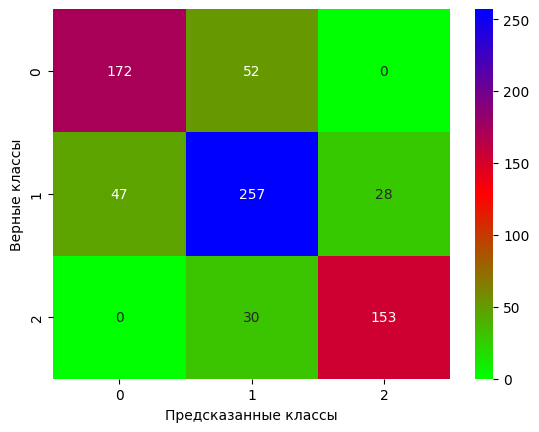

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import seaborn as sns
# Построим матрицу ошибок
y_predict_tree = best_model_tree.predict(X_test)
import seaborn as sns
cm= confusion_matrix(Y_test, y_predict_tree)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='brg_r')
plt.xlabel('Предсказанные классы')
plt.ylabel('Верные классы')